# Deep Learning Neural Networks

Previously in Lesson 1, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
from six.moves import range
%matplotlib inline

### Read data from Lesson 1

In [57]:
pickle_file = 'data/notMNIST_clean_python3.pickle'

dic_file = pickle.load(open(pickle_file, 'rb'))
train_dataset = dic_file["train_dataset"]
train_labels = dic_file["train_labels"]
valid_dataset = dic_file["valid_dataset"]
valid_labels = dic_file["valid_labels"]
test_dataset = dic_file["test_dataset"]
test_labels = dic_file["test_labels"]

del dic_file # freee up memory

print("Examples in train dataset:", len(train_labels) / float(1000), "thousand")
print("Dimensions of train labels", train_labels.shape)
print("Dimensions of train dataset", train_dataset.shape)
print("\nExamples in valid dataset:", len(valid_labels) / float(1000), "thousand")
print("Dimensions of valid labels", valid_labels.shape)
print("Dimensions of valid dataset", valid_dataset.shape)
print("\nExamples in test dataset:", len(test_labels) / float(1000), "thousand")
print("Dimensions of test labels", test_labels.shape)
print("Dimensions of test dataset", test_dataset.shape)

Examples in train dataset: 197.901 thousand
Dimensions of train labels (197901,)
Dimensions of train dataset (197901, 28, 28)

Examples in valid dataset: 9.876 thousand
Dimensions of valid labels (9876,)
Dimensions of valid dataset (9876, 28, 28)

Examples in test dataset: 9.857 thousand
Dimensions of test labels (9857,)
Dimensions of test dataset (9857, 28, 28)


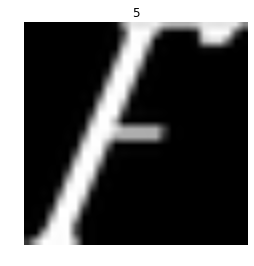

In [59]:
# view images
def print_images(image, label):
    plt.imshow(image, cmap = "gray")
    plt.axis("off")
    plt.title(label)
    plt.show()
    
index = np.random.randint(0, 1000)
print_images(test_dataset[index], test_labels[index])

### Reshape Data intro accordning matrices

In [60]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    # as.type is not needed as the array is already float32 but just in case
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print("Train Shapes --> Dataset: %s   Labels: %s" %(train_dataset.shape, train_labels.shape))
print("Valid Shapes --> Dataset: %s   Labels: %s" %(valid_dataset.shape, valid_labels.shape))
print("Test Shapes  --> Dataset: %s   Labels: %s" %(test_dataset.shape, test_labels.shape))

Train Shapes --> Dataset: (197901, 784)   Labels: (197901, 10)
Valid Shapes --> Dataset: (9876, 784)   Labels: (9876, 10)
Test Shapes  --> Dataset: (9857, 784)   Labels: (9857, 10)


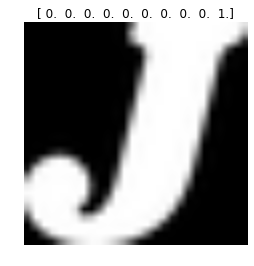

In [61]:
# images
def print_images(image, label):
    plt.imshow(image.reshape(image_size, image_size), cmap = "gray")
    plt.axis("off")
    plt.title(label)
    plt.show()
    
index = np.random.randint(0, 1000)
print_images(train_dataset[index], train_labels[index])

### Multinomial Logistic Regression - Gradient Descent
We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [64]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset_size = 10000

graph = tf.Graph()
with graph.as_default():
    
    """Constants - Input Data
    
    Load the training, validation and test data into constant that 
    attached to the graph
    """
    tf_train_dataset = tf.constant(train_dataset[:train_subset_size])
    tf_train_labels = tf.constant(train_labels[:train_subset_size])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    """    Variables - Weights
    
    These are the parameters that we are going to be training.
    Weights are initiallized randomly and the biases to zero
    """
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    """Training Computation
  
    We multiply the inputs with the weight matrix, and add biases. 
    We compute then calculate the softmax and cross-entropy (it's one 
    operation in TensorFlow, because it's very common, and it can be optimized). 
    We take the average of this cross-entropy across all training examples: that's our loss.
    """
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    """Optimizer
    We now find the minimum of this loss using gradient descent
    """
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    """Predictions for the training, validation and test data.
    
    These are not part of training, but merely here so that we can report
    accuracy figures as we train
    """
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [66]:
%%time
#Running the computation
num_steps = 801

def accuracy(predictions, labels):
    return 100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0]

with tf.Session(graph=graph) as session:
    """  This is a one-time operation which ensures the parameters get initialized as
    we described in the graph: random weights for the matrix, zeros for the
    biases."""
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        """Run the computations. We tell .run() that we want to run the optimizer,
        and get the loss value and the training predictions returned as numpy
        arrays."""
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if step % 100 == 0:
            print("Loss at step %d: %f" %(step, l))
            print("Training Accuracy: \t%.1f%%" % accuracy(predictions, train_labels[:train_subset_size]))
            """Calling .eval() on valid_prediction is basically like calling run(), but
            just to get that one numpy array. Note that it recomputes all its graph
            dependencies."""
            print("Validation Accuracy: \t%.1f%%" %accuracy(valid_prediction.eval(), valid_labels))
    print("\nTest Accuracy: \t\t%.1f%%" %accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 18.558634
Training Accuracy: 	10.3%
Validation Accuracy: 	11.9%
Loss at step 100: 2.343371
Training Accuracy: 	71.9%
Validation Accuracy: 	70.6%
Loss at step 200: 1.872649
Training Accuracy: 	74.8%
Validation Accuracy: 	72.9%
Loss at step 300: 1.623941
Training Accuracy: 	76.0%
Validation Accuracy: 	73.6%
Loss at step 400: 1.455439
Training Accuracy: 	76.7%
Validation Accuracy: 	74.2%
Loss at step 500: 1.330029
Training Accuracy: 	77.4%
Validation Accuracy: 	74.6%
Loss at step 600: 1.231195
Training Accuracy: 	78.0%
Validation Accuracy: 	74.9%
Loss at step 700: 1.150552
Training Accuracy: 	78.5%
Validation Accuracy: 	75.0%
Loss at step 800: 1.083279
Training Accuracy: 	79.0%
Validation Accuracy: 	75.2%

Test Accuracy: 		82.1%
CPU times: user 2min 21s, sys: 16 s, total: 2min 37s
Wall time: 52.1 s


### Stochastic Gradient Descent
The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [68]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    """Input data. For the training data, we use a placeholder that will be fed
    at run time with a training minibatch"""
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    """    Variables - Weights
    
    These are the parameters that we are going to be training.
    Weights are initiallized randomly and the biases to zero
    """
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    """Training Computation
  
    We multiply the inputs with the weight matrix, and add biases. 
    We compute then calculate the softmax and cross-entropy (it's one 
    operation in TensorFlow, because it's very common, and it can be optimized). 
    We take the average of this cross-entropy across all training examples: that's our loss.
    """
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    """Optimizer
    We now find the minimum of this loss using gradient descent
    """
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    """Predictions for the training, validation and test data.
    
    These are not part of training, but merely here so that we can report
    accuracy figures as we train
    """
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [70]:
%%time
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        
        """This offset is an integer of the batch size, Such that 
        we are taking the batches not in the order they are presented."""
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size)]
        batch_labels = train_labels[offset:(offset + batch_size)]
        
        """Prepare a dictionary telling the session where to feed the minibatch.
        The key of the dictionary is the placeholder node of the graph to be fed,
        and the value is the numpy array to feed to it."""
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        # Perform calculations
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        
        # Give feedback every 500 steps
        if step % 500 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: \t%.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: \t%.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("\nTest accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 17.499760
Minibatch accuracy: 	13.3%
Validation accuracy: 	12.0%
Minibatch loss at step 500: 1.993294
Minibatch accuracy: 	68.0%
Validation accuracy: 	75.0%
Minibatch loss at step 1000: 1.342129
Minibatch accuracy: 	79.7%
Validation accuracy: 	76.3%
Minibatch loss at step 1500: 0.968957
Minibatch accuracy: 	81.2%
Validation accuracy: 	76.7%
Minibatch loss at step 2000: 1.997852
Minibatch accuracy: 	67.2%
Validation accuracy: 	77.7%
Minibatch loss at step 2500: 1.030935
Minibatch accuracy: 	80.5%
Validation accuracy: 	77.8%
Minibatch loss at step 3000: 0.841187
Minibatch accuracy: 	81.2%
Validation accuracy: 	78.2%

Test accuracy: 85.2%
CPU times: user 7.84 s, sys: 2.14 s, total: 9.98 s
Wall time: 4.97 s


### Stochastic Gradient Descent + Hidden Layer
Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

In [ ]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    """Input data. For the training data, we use a placeholder that will be fed
    at run time with a training minibatch"""
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    """    Variables - Weights
    
    These are the parameters that we are going to be training.
    Weights are initiallized randomly and the biases to zero
    """
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    """Training Computation
  
    We multiply the inputs with the weight matrix, and add biases. 
    We compute then calculate the softmax and cross-entropy (it's one 
    operation in TensorFlow, because it's very common, and it can be optimized). 
    We take the average of this cross-entropy across all training examples: that's our loss.
    """
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    """Optimizer
    We now find the minimum of this loss using gradient descent
    """
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    """Predictions for the training, validation and test data.
    
    These are not part of training, but merely here so that we can report
    accuracy figures as we train
    """
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [71]:
%%time
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        
        """This offset is an integer of the batch size, Such that 
        we are taking the batches not in the order they are presented."""
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size)]
        batch_labels = train_labels[offset:(offset + batch_size)]
        
        """Prepare a dictionary telling the session where to feed the minibatch.
        The key of the dictionary is the placeholder node of the graph to be fed,
        and the value is the numpy array to feed to it."""
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        # Perform calculations
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        
        # Give feedback every 500 steps
        if step % 500 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: \t%.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: \t%.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("\nTest accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 16.924141
Minibatch accuracy: 	10.9%
Validation accuracy: 	12.9%
Minibatch loss at step 500: 1.968161
Minibatch accuracy: 	74.2%
Validation accuracy: 	73.9%
Minibatch loss at step 1000: 1.413652
Minibatch accuracy: 	76.6%
Validation accuracy: 	76.1%
Minibatch loss at step 1500: 1.069954
Minibatch accuracy: 	78.1%
Validation accuracy: 	76.7%
Minibatch loss at step 2000: 1.822005
Minibatch accuracy: 	69.5%
Validation accuracy: 	77.4%
Minibatch loss at step 2500: 0.991371
Minibatch accuracy: 	78.9%
Validation accuracy: 	78.0%
Minibatch loss at step 3000: 0.712138
Minibatch accuracy: 	84.4%
Validation accuracy: 	77.9%

Test accuracy: 85.2%
CPU times: user 7.98 s, sys: 2.19 s, total: 10.2 s
Wall time: 5.11 s


In [73]:
batch_size = 128
hidden_layer_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    """Input data. For the training data, we use a placeholder that will be fed
    at run time with a training minibatch"""
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    """    Variables - Weights
    
    These are the parameters that we are going to be training.
    Weights are initiallized randomly and the biases to zero
    """
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_layer_nodes]))
    
    weights2 = tf.Variable(tf.truncated_normal([hidden_layer_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    """Training Computation
  
    We multiply the inputs with the weight matrix, and add biases. 
    We compute then calculate the softmax and cross-entropy (it's one 
    operation in TensorFlow, because it's very common, and it can be optimized). 
    We take the average of this cross-entropy across all training examples: that's our loss.
    """
    hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(hidden, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    """Optimizer
    We now find the minimum of this loss using gradient descent
    """
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    """Predictions for the training, validation and test data.
    
    These are not part of training, but merely here so that we can report
    accuracy figures as we train
    """
    train_prediction = tf.nn.softmax(logits)
    
    hidden_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(hidden_valid, weights2) + biases2)
    
    hidden_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(hidden_test, weights2) + biases2)

In [74]:
%%time
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        
        """This offset is an integer of the batch size, Such that 
        we are taking the batches not in the order they are presented."""
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size)]
        batch_labels = train_labels[offset:(offset + batch_size)]
        
        """Prepare a dictionary telling the session where to feed the minibatch.
        The key of the dictionary is the placeholder node of the graph to be fed,
        and the value is the numpy array to feed to it."""
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        # Perform calculations
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        
        # Give feedback every 500 steps
        if step % 500 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: \t%.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: \t%.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("\nTest accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 390.293579
Minibatch accuracy: 	11.7%
Validation accuracy: 	24.7%
Minibatch loss at step 500: 21.466150
Minibatch accuracy: 	77.3%
Validation accuracy: 	80.7%
Minibatch loss at step 1000: 13.902340
Minibatch accuracy: 	87.5%
Validation accuracy: 	80.5%
Minibatch loss at step 1500: 7.822052
Minibatch accuracy: 	87.5%
Validation accuracy: 	81.5%
Minibatch loss at step 2000: 5.972208
Minibatch accuracy: 	79.7%
Validation accuracy: 	82.5%
Minibatch loss at step 2500: 1.607383
Minibatch accuracy: 	82.8%
Validation accuracy: 	81.4%
Minibatch loss at step 3000: 1.943299
Minibatch accuracy: 	88.3%
Validation accuracy: 	81.7%

Test accuracy: 88.2%
CPU times: user 3min 52s, sys: 10.6 s, total: 4min 3s
Wall time: 1min 25s
